# (Generalized) Linear and Hierarchical Linear Models in PyMC3

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pymc3 import  *
import theano
import pandas as pd
from statsmodels.formula.api import glm as glm_sm
import statsmodels.api as sm
from pandas.plotting import scatter_matrix

## Linear Regression

Lets generate some data with known slope and intercept and fit a simple linear GLM.

In [2]:
size = 50
true_intercept = 1
true_slope = 2
x = np.linspace(0, 1, size)
y = true_intercept + x*true_slope + np.random.normal(scale=.5, size=size)
data = {'x': x, 'y': y}

The `glm.linear_component()` function can be used to generate the output variable y_est and coefficients of the specified linear model.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, x, Intercept]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:04<00:00, 1198.90draws/s]


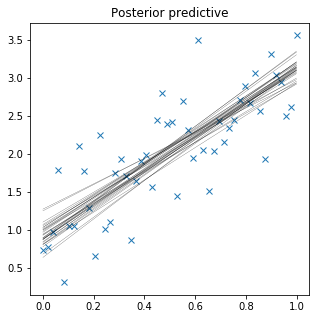

In [3]:
with Model() as model:
    lm = glm.LinearComponent.from_formula('y ~ x', data)
    sigma = Uniform('sigma', 0, 20)
    y_obs = Normal('y_obs', mu=lm.y_est, sigma=sigma, observed=y)
    trace = sample(2000, cores=2)

plt.figure(figsize=(5, 5))
plt.plot(x, y, 'x')
plot_posterior_predictive_glm(trace)

Since there are a couple of general linear models that are being used over and over again (Normally distributed noise, logistic regression etc), the `glm.glm()` function simplifies the above step by creating the likelihood (y_obs) and its priors (sigma) for us. Since we are working in the model context, the random variables are all added to the model behind the scenes. This function also automatically finds a good starting point which it returns.

Note that the below call to `glm()` is producing exactly the same model as above, just more succinctly.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x, Intercept]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:03<00:00, 1323.61draws/s]


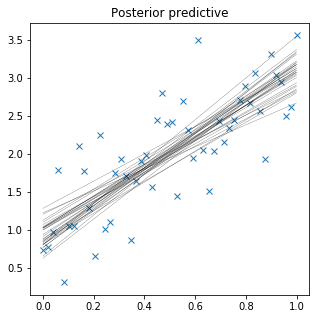

In [4]:
with Model() as model:
    GLM.from_formula('y ~ x', data)
    trace = sample(2000, cores=2)

plt.figure(figsize=(5, 5))
plt.plot(x, y, 'x')
plot_posterior_predictive_glm(trace)

## Robust GLM

Lets try the same model but with a few outliers in the data.

In [5]:
x_out = np.append(x, [.1, .15, .2])
y_out = np.append(y, [8, 6, 9])
data_outlier = dict(x=x_out, y=y_out)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x, Intercept]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:03<00:00, 1371.98draws/s]


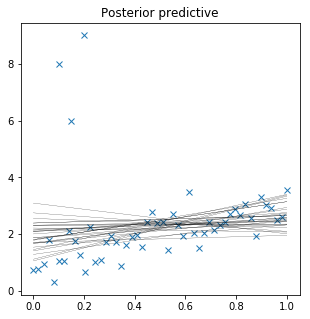

In [6]:
with Model() as model:
    GLM.from_formula('y ~ x', data_outlier)
    trace = sample(2000, cores=2)

plt.figure(figsize=(5, 5))
plt.plot(x_out, y_out, 'x')
plot_posterior_predictive_glm(trace)

Because the normal distribution does not have a lot of mass in the tails, an outlier will affect the fit strongly.

Instead, we can replace the Normal likelihood with a student T distribution which has heavier tails and is more robust towards outliers. While this could be done with the `linear_compoment()` function and manually defining the T likelihood we can use the `glm()` function for more automation. By default this function uses a normal likelihood. To define the usage of a T distribution instead we can pass a family object that contains information on how to link the output to `y_est` (in this case we explicitly use the Identity link function which is also the default) and what the priors for the T distribution are. Here we fix the degrees of freedom `nu` to 1.5.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lam, x, Intercept]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:03<00:00, 1266.86draws/s]


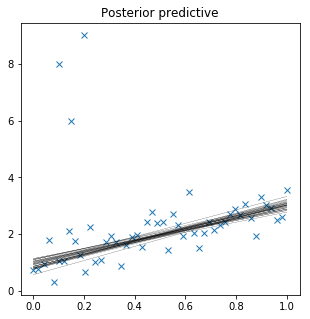

In [7]:
with Model() as model_robust:
    family = glm.families.StudentT(link=glm.families.Identity(),  
                                   priors={'nu': 1.5,
                                           'lam': Uniform.dist(0, 20)})
    GLM.from_formula('y ~ x', data_outlier, family=family)    
    trace = sample(2000, cores=2)

plt.figure(figsize=(5, 5))
plt.plot(x_out, y_out, 'x')
plot_posterior_predictive_glm(trace)

## Hierarchical GLM

In [8]:
sat_data = pd.read_csv(get_data('Guber1999data.txt'))

In [9]:
with Model() as model_sat:
    grp_mean = Normal('grp_mean', mu=0, sigma=10)
    grp_sd = Uniform('grp_sd', 0, 200)
    # Define priors for intercept and regression coefficients.
    priors = {'Intercept': Normal.dist(mu=sat_data.sat_t.mean(), sigma=sat_data.sat_t.std()),
              'spend': Normal.dist(mu=grp_mean, sigma=grp_sd),
              'stu_tea_rat': Normal.dist(mu=grp_mean, sigma=grp_sd),
              'salary': Normal.dist(mu=grp_mean, sigma=grp_sd),
              'prcnt_take': Normal.dist(mu=grp_mean, sigma=grp_sd)
              }
    GLM.from_formula(
        'sat_t ~ spend + stu_tea_rat + salary + prcnt_take', sat_data, priors=priors)
    trace_sat = sample(2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, prcnt_take, salary, stu_tea_rat, spend, Intercept, grp_sd, grp_mean]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:22<00:00, 223.59draws/s]


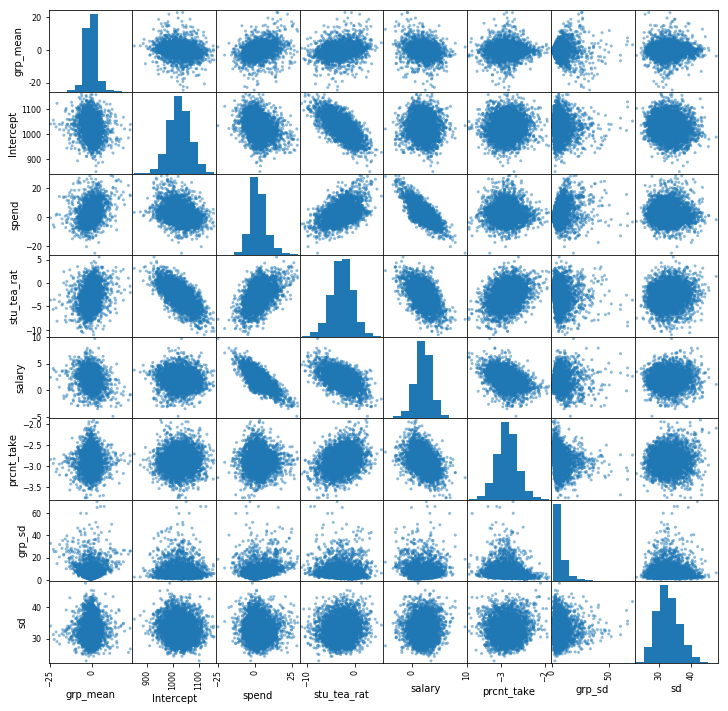

In [10]:
scatter_matrix(trace_to_dataframe(trace_sat), figsize=(12,12));

In [11]:
with Model() as model_sat:
    grp_mean = Normal('grp_mean', mu=0, sigma=10)
    grp_prec = Gamma('grp_prec', alpha=1, beta=.1, testval=1.)
    slope = StudentT.dist(mu=grp_mean, lam=grp_prec, nu=1)
    intercept = Normal.dist(mu=sat_data.sat_t.mean(), sigma=sat_data.sat_t.std())
    GLM.from_formula('sat_t ~ spend + stu_tea_rat + salary + prcnt_take', sat_data,
        priors={'Intercept': intercept, 'Regressor': slope})
    trace_sat = sample(2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, prcnt_take, salary, stu_tea_rat, spend, Intercept, grp_prec, grp_mean]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:32<00:00, 152.41draws/s]
The number of effective samples is smaller than 25% for some parameters.


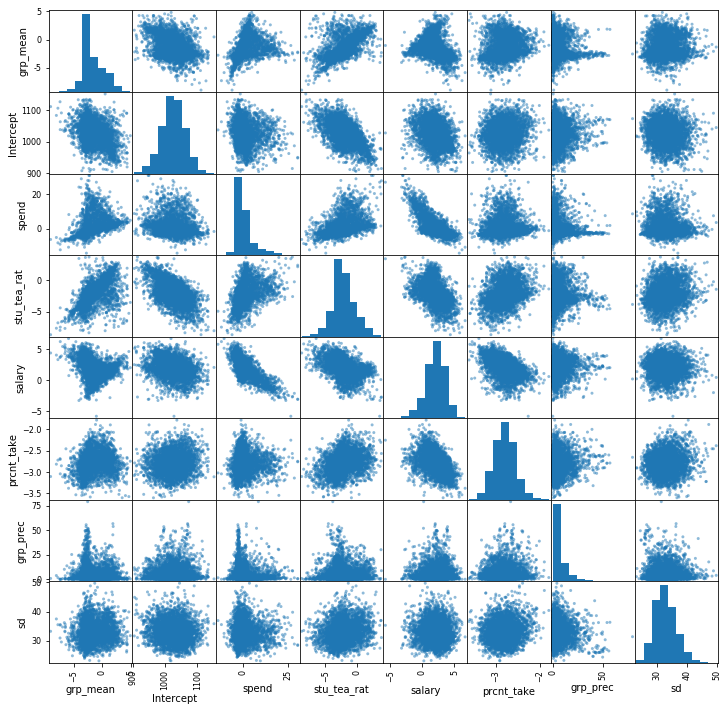

In [12]:
scatter_matrix(trace_to_dataframe(trace_sat), figsize=(12,12));

In [13]:
tdf_gain = 5.
with Model() as model_sat:
    grp_mean = Normal('grp_mean', mu=0, sigma=10)
    grp_prec = Gamma('grp_prec', alpha=1, beta=.1, testval=1.)
    slope = StudentT.dist(mu=grp_mean, lam=grp_prec, nu=1) #grp_df)
    intercept = Normal.dist(mu=sat_data.sat_t.mean(), sigma=sat_data.sat_t.std())
    GLM.from_formula('sat_t ~ spend + stu_tea_rat + salary + prcnt_take', sat_data,
                priors={'Intercept': intercept, 'Regressor': slope})

    trace_sat = sample(2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, prcnt_take, salary, stu_tea_rat, spend, Intercept, grp_prec, grp_mean]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:31<00:00, 158.13draws/s]
The number of effective samples is smaller than 25% for some parameters.


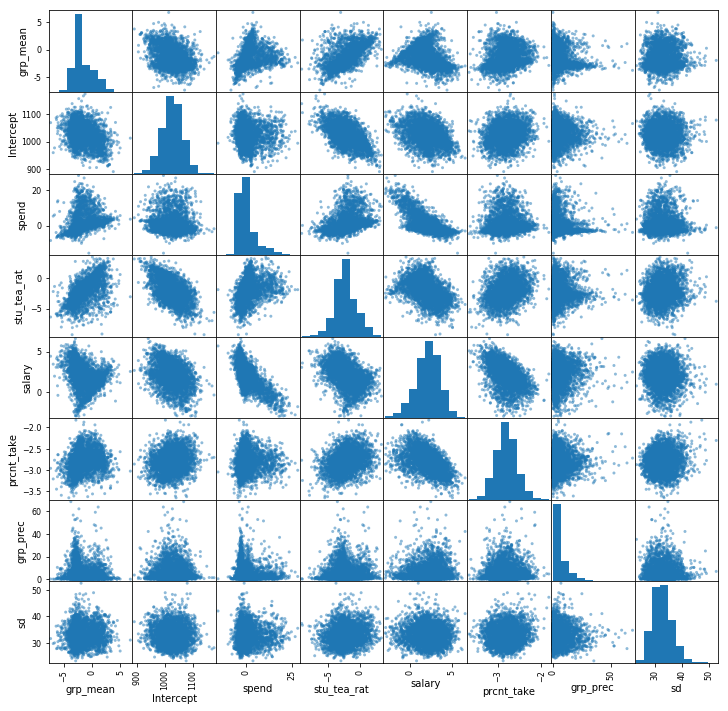

In [14]:
scatter_matrix(trace_to_dataframe(trace_sat), figsize=(12,12));

## Logistic Regression

In [15]:
htwt_data = pd.read_csv(get_data('HtWt.csv'))
htwt_data.head()

,male,height,weight
0,0,63.2,168.7
1,0,68.7,169.8
2,0,64.8,176.6
3,0,67.9,246.8
4,1,68.9,151.6


In [16]:
m = glm_sm('male ~ height + weight', htwt_data, family=sm.families.Binomial()).fit()
print(m.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   male   No. Observations:                   70
Model:                            GLM   Df Residuals:                       67
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28.298
Date:                Sun, 10 Mar 2019   Deviance:                       56.597
Time:                        10:29:58   Pearson chi2:                     62.8
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -45.2059     10.887     -4.152      0.000     -66.545     -23.867
height         0.6571      0.164      4.018      0.0

In [20]:
with Model() as model_htwt:
    GLM.from_formula('male ~ height + weight', htwt_data, family=glm.families.Binomial())
    trace_htwt = sample(2000, cores=2, init='adapt_diag') # default init with jitter can cause problem

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [weight, height, Intercept]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:32<00:00, 153.89draws/s]


                mean        std        min        25%        50%        75%  \
Intercept -49.078048  11.105882 -93.009681 -56.246726 -48.223021 -41.340962   
height      0.713442   0.166503   0.214603   0.599614   0.699343   0.820303   
weight      0.010296   0.010869  -0.026486   0.003090   0.010310   0.017617   

                 max  
Intercept -18.360234  
height      1.354136  
weight      0.046956  
P(weight < 0) =  0.17125
P(height < 0) =  0.0


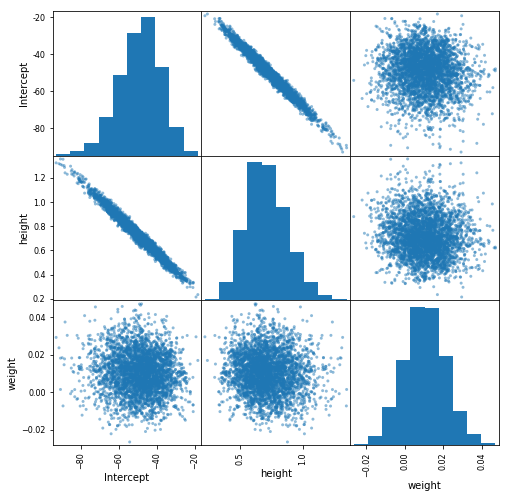

In [21]:
trace_df = trace_to_dataframe(trace_htwt)
print(trace_df.describe().drop('count').T)
scatter_matrix(trace_df, figsize=(8, 8))
print("P(weight < 0) = ", (trace_df['weight'] < 0).mean())
print("P(height < 0) = ", (trace_df['height'] < 0).mean())

## Bayesian Logistic Lasso

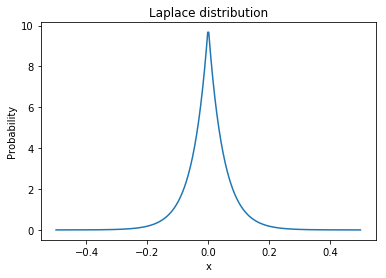

In [22]:
lp = Laplace.dist(mu=0, b=0.05)
x_eval = np.linspace(-.5, .5, 300)
plt.plot(x_eval, theano.tensor.exp(lp.logp(x_eval)).eval())
plt.xlabel('x')
plt.ylabel('Probability')
plt.title('Laplace distribution');

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [weight, height, Intercept]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:09<00:00, 215.48draws/s]
The acceptance probability does not match the target. It is 0.889586968323601, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


                mean       std        min        25%        50%        75%  \
Intercept -25.249432  6.442224 -44.206556 -29.388185 -24.788700 -21.205685   
height      0.350639  0.100371   0.041930   0.285759   0.348008   0.410429   
weight      0.012410  0.009459  -0.010620   0.005539   0.012013   0.018353   

                max  
Intercept -7.883852  
height     0.668336  
weight     0.054574  


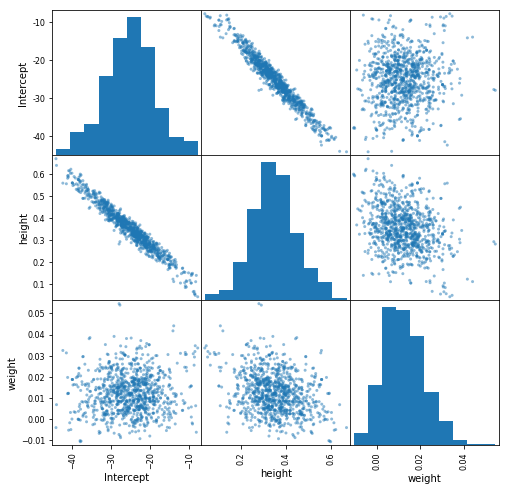

In [24]:
with Model() as model_lasso:
    # Define priors for intercept and regression coefficients.
    priors = {'Intercept': Normal.dist(mu=0, sigma=50),
              'Regressor': Laplace.dist(mu=0, b=0.05)
    }
    GLM.from_formula('male ~ height + weight', htwt_data, family=glm.families.Binomial(),
                    priors=priors)
    
    trace_lasso = sample(500, cores=2, init='adapt_diag')
    
trace_df = trace_to_dataframe(trace_lasso)
scatter_matrix(trace_df, figsize=(8, 8));
print(trace_df.describe().drop('count').T)